# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import os
import re
import tqdm
import time
import glob

import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from skimage.io import imread
from collections import Counter
from keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras import layers
from skimage.transform import resize

from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from sklearn.model_selection import train_test_split 
from tensorflow.keras.applications import InceptionV3 
from tensorflow.keras.activations import tanh, softmax
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import TextVectorization, Dense, Activation, Embedding, Dropout

%matplotlib inline

In [2]:
np.random.seed(2)
rn.seed(3)
tf.random.set_seed(2)

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='/kaggle/input/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
# Read captions.txt into dataframe
captions_df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
captions_df.shape

(40455, 2)

Captions
Dogs playing in the yard .
Five dogs play in a large fenced yard bordering a group of autumnal trees .
Four dogs are playing in a circle and one black do is walking away .
Four dogs in a circle on the grass in the distance and a black dog on the grass in forefront .
Several dogs of different breeds play in a backyard .


[None, None, None, None, None]

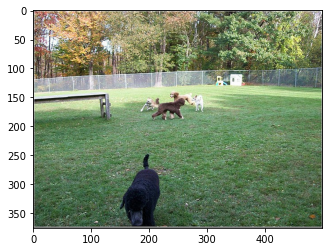

In [6]:
#Visualise both the images & text present in the dataset
random_choice =rn.choice(os.listdir(images))
image = imread(images + '/' + random_choice)
plt.imshow(image)
print("Captions")
[print(caption) for caption in captions_df.caption[captions_df.image == random_choice]]

In [7]:
images

'/kaggle/input/flickr8k/Images'

Captions
A smiling boy with hat playing in the snow .
A young child coming down a snowy hill with snow flying around him near tiretracks .
A young child slides down a snow slope while smiling .
Little boy sledding down a snow covered hill .
Young boy in a winter hat sliding down a snowy hill .


[None, None, None, None, None]

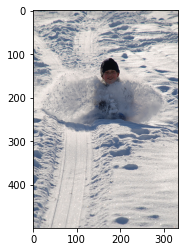

In [8]:
#Visualise both the images & text present in the dataset
random_choice =rn.choice(os.listdir(images))
image = imread(images + '/' + random_choice)
plt.imshow(image)
print("Captions")
[print(caption) for caption in captions_df.caption[captions_df.image == random_choice]]

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_img_id= captions_df.image                            #store all the image id here
all_img_vector= images + '/' + all_img_id                #store all the image path here
annotations= captions_df.caption                         #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df                                                       # Final DataFrame

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A rock climber in a red shirt .


In [10]:
df.shape

(40455, 3)

In [11]:
# Check null Values
df.isna().sum()

ID          0
Path        0
Captions    0
dtype: int64

In [12]:
# overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [13]:
#Create a list which contains all the captions
annotations= [ caption for caption in df.Captions] 

#add the <start> & <end> token to all those captions as well
df.Captions = df.Captions.apply(lambda x: '<start> '+x+' <end>')
#Create a list which contains all the path to the images
all_img_path=[path for path in df.Path]

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [14]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl in a pink dress going in...


In [15]:
#Create the vocabulary & the counter for the captions
# Data With No Pre Processed Text
vocabulary= []

for caption in annotations:
    for word in caption.split():
        vocabulary.append(word.lower())

        
val_count=dict(Counter(vocabulary))
val_count

{'a': 62986,
 'child': 1545,
 'in': 18974,
 'pink': 735,
 'dress': 348,
 'is': 9345,
 'climbing': 502,
 'up': 1260,
 'set': 108,
 'of': 6713,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 50,
 '.': 36577,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 510,
 'little': 1768,
 'playhouse': 6,
 'the': 18418,
 'to': 3173,
 'her': 1178,
 'cabin': 4,
 'black': 3832,
 'dog': 8136,
 'and': 8851,
 'spotted': 37,
 'are': 3504,
 'fighting': 132,
 'tri-colored': 14,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10743,
 'road': 388,
 'white': 3940,
 'brown': 2563,
 'spots': 29,
 'staring': 57,
 'at': 2914,
 'street': 943,
 'two': 5638,
 'dogs': 2125,
 'different': 45,
 'breeds': 5,
 'looking': 742,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 306,
 'paint': 61,
 'sits': 577,
 'front': 1386,
 'painted': 63,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1235,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 '

In [16]:
#Visualise the top 30 occuring words in the captions
# Un Processed Data
#write your code here

count = pd.DataFrame()
count['Names'] = val_count.keys()
count['total_count'] = val_count.values()
count = count.sort_values(by='total_count',ascending=False)
count[:30]

,Names,total_count
0,a,62986
14,.,36577
2,in,18974
22,the,18418
37,on,10743
5,is,9345
28,and,8851
27,dog,8136
34,with,7765
74,man,7265


In [17]:

fig = px.bar(count[:30], x= 'Names',y='total_count',title='Top 30 occuring words in the captions')
fig.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [18]:
# create the tokenizer

#your code here

tokenizer = Tokenizer(
    num_words= 5000, # total vocaublary to top 5,000 words
    filters= '"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token='UNK' 
)

tokenizer.fit_on_texts(df.Captions)
tokenized_annotations = tokenizer.texts_to_sequences(df.Captions)

In [19]:
# Create word-to-index and index-to-word mappings.

#your code here
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

In [20]:
# Word To Index 
word_to_index

{'UNK': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'white': 15,
 'black': 16,
 'boy': 17,
 'are': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'at': 23,
 'people': 24,
 'water': 25,
 'red': 26,
 'young': 27,
 'brown': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'dogs': 32,
 'running': 33,
 'through': 34,
 'playing': 35,
 'while': 36,
 'shirt': 37,
 'down': 38,
 'standing': 39,
 'ball': 40,
 'little': 41,
 'grass': 42,
 'snow': 43,
 'child': 44,
 'person': 45,
 'jumping': 46,
 'over': 47,
 'three': 48,
 'front': 49,
 'sitting': 50,
 'holding': 51,
 'up': 52,
 'field': 53,
 'small': 54,
 'by': 55,
 'large': 56,
 'green': 57,
 'one': 58,
 'group': 59,
 'yellow': 60,
 'her': 61,
 'walking': 62,
 'children': 63,
 'men': 64,
 'into': 65,
 'air': 66,
 'beach': 67,
 'near': 68,
 'mouth': 69,
 'jumps': 70,
 'another': 71,
 'for': 72,
 'street': 73,
 'runs': 74,
 'its': 75,
 '

In [21]:
# Index to Word
index_to_word

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'shirt',
 38: 'down',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'snow',
 44: 'child',
 45: 'person',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'holding',
 52: 'up',
 53: 'field',
 54: 'small',
 55: 'by',
 56: 'large',
 57: 'green',
 58: 'one',
 59: 'group',
 60: 'yellow',
 61: 'her',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'runs',
 75: 'its',
 7

In [22]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl in a pink dress going in...


In [23]:

# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here

vocabulary_text_processing= []
caption_text_processing = df.Captions.apply(lambda x: x)

for caption in caption_text_processing:
    for word in caption.split():
        vocabulary_text_processing.append(word.lower())

        
val_count=dict(Counter(vocabulary_text_processing))

count = pd.DataFrame()                                                    # Create a Count DataFrame
count['Names'] = val_count.keys()                                         # Create a Name Column and asign the words & all special characters split by ' '
count['total_count'] = val_count.values()                                 # Create a Column total count and assign the count 

filtered_values = list(word_to_index.keys())                              # Create a list to filter out all special charaters
filtered_values.append('<start>')                                         # Keep Start and End in Filtered List
filtered_values.append('<end>')                   

count = count[count.Names.isin(filtered_values)]                          # filter Special Charaters
count = count.sort_values(by='total_count',ascending=False)               # Sort Data Frame by count 

fig = px.bar(count[:30], x= 'Names',y='total_count',title='Top 30 occuring words after text processing')
fig.show()                                                                # Plot top 30 occuring words after text processing

Captions
A large yellow vehicle leads two others in a race .
[2, 56, 60, 502, 1262, 14, 286, 5, 2, 159]
A yellow truck with Casterol branding leads a white truck and blue truck down the road .
[2, 60, 463, 11, 1, 1, 1262, 2, 15, 463, 9, 31, 463, 38, 6, 152]
trucks race around a racetrack , the yellow truck with the number five leads , followed by number 22 and number 29 .
[2254, 159, 100, 2, 693, 6, 60, 463, 11, 6, 386, 301, 1262, 1395, 55, 386, 1, 9, 386, 1]
Trucks race in an obstacle course .
[2254, 159, 5, 29, 360, 341]
Trucks racing
[2254, 231]


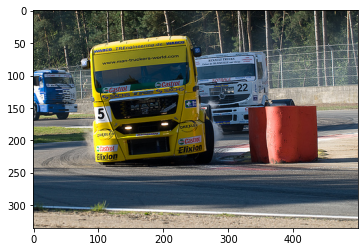

In [24]:
#Visualise both the images & text present in the dataset & 
random_choice =rn.choice(os.listdir(images))
image = imread(images + '/' + random_choice)
plt.imshow(image)
print("Captions")

caption_list = [caption for caption in captions_df.caption[captions_df.image == random_choice]]
caption_sequence = tokenizer.texts_to_sequences(caption_list)
for i in range(0,len(caption_list)):
    print(caption_list[i])
    print(caption_sequence[i])

In [25]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
#your code here
cap_vector= pad_sequences(tokenized_annotations,padding='post') 

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [26]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [27]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl in a pink dress going in...


In [28]:
#write your code here for creating the function. This function should return images & their path

def preprocess_image(image_path):
    #write your pre-processing steps here
    image = tf.io.read_file(image_path)                           # Read the Image from target location
    image = tf.image.decode_jpeg(image, channels=3)               # Decode Image 
    image = tf.image.resize(image, (299, 299))                    # Resize Image to 299 x 299 Pixels & return data in float
    image = preprocess_input(image)                               # Scale Image to -1, 1 Scale and Return data in float 
    return image,image_path

2023-01-08 09:03:32.250824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:32.254385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:32.255137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:32.258508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(299, 299, 3)


2023-01-08 09:03:32.258867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:32.259586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:32.260245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:34.657515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:03:34.658686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

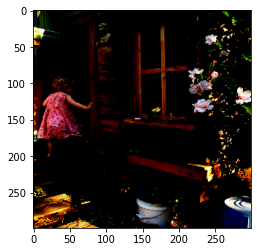

In [29]:
# Processed Image Shape
Image_Processed = preprocess_image('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')[0]
print(Image_Processed.shape)
plt.imshow(Image_Processed)

(500, 375, 3)


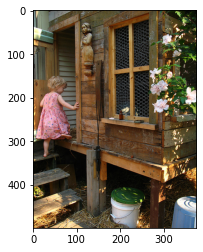

In [30]:
# Un Processed Image Shape
image_unprocessed = imread("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")
print(image_unprocessed.shape)
plt.imshow(image_unprocessed)

In [31]:
type(Image_Processed)

tensorflow.python.framework.ops.EagerTensor

In [32]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

BATCH_SIZE = 64

uniq_images =  sorted(list(set(all_img_vector)))
df_transformed = tf.data.Dataset.from_tensor_slices(uniq_images)
df_transformed = df_transformed.shuffle(BATCH_SIZE * 8)
df_transformed = df_transformed.map(preprocess_image, num_parallel_calls=AUTOTUNE)
df_transformed = df_transformed.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [33]:
df_transformed

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [34]:
for image,path in df_transformed:
    print(image.shape)
    print(path)
    break

2023-01-08 09:03:36.061788: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 299, 299, 3)
tf.Tensor(
[b'/kaggle/input/flickr8k/Images/1362128028_8422d53dc4.jpg'
 b'/kaggle/input/flickr8k/Images/111497985_38e9f88856.jpg'
 b'/kaggle/input/flickr8k/Images/1359101233_16c2c150e3.jpg'
 b'/kaggle/input/flickr8k/Images/1387461595_2fe6925f73.jpg'
 b'/kaggle/input/flickr8k/Images/107318069_e9f2ef32de.jpg'
 b'/kaggle/input/flickr8k/Images/1118557877_736f339752.jpg'
 b'/kaggle/input/flickr8k/Images/1235681222_819231767a.jpg'
 b'/kaggle/input/flickr8k/Images/1311132744_5ffd03f831.jpg'
 b'/kaggle/input/flickr8k/Images/1355833561_9c43073eda.jpg'
 b'/kaggle/input/flickr8k/Images/141755292_7a0b3364cf.jpg'
 b'/kaggle/input/flickr8k/Images/1449692616_60507875fb.jpg'
 b'/kaggle/input/flickr8k/Images/1093716555_801aacef79.jpg'
 b'/kaggle/input/flickr8k/Images/1368338041_6b4077ca98.jpg'
 b'/kaggle/input/flickr8k/Images/1262077938_8b9516c273.jpg'
 b'/kaggle/input/flickr8k/Images/1285874746_486731a954.jpg'
 b'/kaggle/input/flickr8k/Images/1418503947_953d373632.jpg'
 b'/kaggle/inp

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [35]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.output   #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87924736/87910968 [==============================] - 4s 0us/step


In [36]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [37]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)


feature_vector_path = '/kaggle/working/feature_vector2/'                                                      # Kaggle Input is read only so we save files to write location
os.makedirs(feature_vector_path, exist_ok=True)

for image,path in tqdm.tqdm(df_transformed):                                                                  # tqdm for Progress Bar, image -> Preprocessed image data, path -> unprocessed image location
        feature_vector_batch = image_features_extract_model(image)                                            # Get Feature Vector
        
        try:
            feature_vector_batch = tf.reshape(feature_vector_batch,(BATCH_SIZE,8*8,2048))                     # Reshape feature vector in order of (batch_size, 8*8, 2048) , Batch_size = 64
        except:
            print('Last Remaning feature vector Batch ' + str(feature_vector_batch.shape[0]))
            feature_vector_batch = tf.reshape(feature_vector_batch,(feature_vector_batch.shape[0],8*8,2048))  # Saving last remaing vectors as a batch
            
        for batch_feature, path in zip(feature_vector_batch, path):
            path = feature_vector_path + path.numpy().decode("utf-8").split('/')[-1]                          # Set Write Location path for file
            np.save(path, batch_feature.numpy())                                                              # Save to location

100%|██████████| 127/127 [00:56<00:00,  2.24it/s]

Last Remaning feature vector Batch 27


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [38]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl in a pink dress going in...


In [39]:
#write your code here

feature_vector_path = [path.replace('input/flickr8k/Images','working/feature_vector2') +'.npy'  for path in all_img_path]
path_train, path_test, cap_train, cap_test = train_test_split( feature_vector_path,cap_vector,test_size=0.2 ,random_state = 2)

In [40]:
img_test = [path.replace('working/feature_vector2','input/flickr8k/Images')  for path in path_test] 
img_test = [path.replace('.npy','')  for path in img_test]

In [41]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [42]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    img_tensor = np.load(image.decode("utf-8"))# write your code here to extract the features from the dictionary stored earlier
    return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [43]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image_path,caption):
    
    # your code goes here to create the dataset & transform it
    tensor  = (image_path,caption)
    dataset = tf.data.Dataset.from_tensor_slices(tensor)
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(lambda x1,x2 : tf.numpy_function(map_func, [x1, x2], [tf.float32, tf.int32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return dataset



In [44]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [45]:
train_dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [46]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [47]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train)//BATCH_SIZE    #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test)//BATCH_SIZE      #len(total test images) // BATCH_SIZE

### Encoder

In [48]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense  = Dense(embed_dim, activation='relu')   #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        return features

In [49]:
encoder=Encoder(embedding_dim)

### Attention model

In [50]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units) #build your Dense layer
        self.W2 = Dense(units) #build your Dense layer
        self.V = Dense(1)      #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,axis = 1)                                        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =  tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = softmax(self.V(score),axis = 1)                       # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features                                           # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1)                                # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [51]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)            # iniitalise your Attention model with units
        self.embed = Embedding(vocab_size, embed_dim)           # build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units)                             #build your Dense layer
        self.d2 = Dense(vocab_size)                             #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights =  self.attention(features,hidden) #create your context vector & attention weights from attention model
        embed =  self.embed(x)                               # embed your input to shape: (batch_size, 1, embedding_dim)
        expand_vector = tf.expand_dims(context_vector, axis = 1)
        embed =  tf.concat([expand_vector,embed],axis= -1)   # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)                       # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        
        output = tf.reshape(output, (-1, output.shape[2]))   # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output)                             # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
tokenizer.word_index['<start>']

3

In [54]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features , hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [55]:
optimizer = Adam() #define the optimizer
loss_object = SparseCategoricalCrossentropy(from_logits=True,reduction='none') #define your loss object

In [56]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
checkpoint_path = "/kaggle/working/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [59]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        output_features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            pred, hidden, attention_weights_out = decoder(dec_input, output_features, hidden)
            loss += loss_function(target[:, i], pred)
            dec_input = tf.expand_dims(target[:, i], 1)
        
        average_loss = loss/int(target.shape[1])
        trainable_parms = encoder.trainable_variables + decoder.trainable_variables
        Gradients = tape.gradient(loss, trainable_parms)
        optimizer.apply_gradients(grads_and_vars = zip(Gradients, trainable_parms))
  
    return loss, average_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [60]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        output_features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            pred, hidden, attention_weights_out = decoder(dec_input, output_features, hidden)
            loss = loss + loss_function(real=target[:, i], pred = pred)
            dec_input = tf.expand_dims(target[:, i], 1)
        
        average_loss = loss/int(target.shape[1])
        trainable_parms = encoder.trainable_variables + decoder.trainable_variables
        Gradients = tape.gradient(loss, trainable_parms)
        optimizer.apply_gradients(grads_and_vars = zip(Gradients, trainable_parms))
  
    return loss, average_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss  = total_loss + t_loss
        avg_test_loss = total_loss / train_num_steps
        
    return avg_test_loss

In [62]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm.tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.272, & test loss is 0.261
Time taken for 1 epoch 203.090434551239 sec

Test loss has been reduced from 100.000 to 0.261


 13%|█▎        | 2/15 [04:42<28:11, 130.15s/it]

For epoch: 2, the train loss is 0.968, & test loss is 0.229
Time taken for 1 epoch 78.72597885131836 sec

Test loss has been reduced from 0.261 to 0.229


 20%|██        | 3/15 [06:00<21:18, 106.54s/it]

For epoch: 3, the train loss is 0.877, & test loss is 0.211
Time taken for 1 epoch 78.26590299606323 sec

Test loss has been reduced from 0.229 to 0.211


 27%|██▋       | 4/15 [07:19<17:29, 95.40s/it] 

For epoch: 4, the train loss is 0.818, & test loss is 0.198
Time taken for 1 epoch 78.13661885261536 sec

Test loss has been reduced from 0.211 to 0.198


 33%|███▎      | 5/15 [08:37<14:51, 89.12s/it]

For epoch: 5, the train loss is 0.767, & test loss is 0.186
Time taken for 1 epoch 77.80298686027527 sec

Test loss has been reduced from 0.198 to 0.186
For epoch: 6, the train loss is 0.724, & test loss is 0.176
Time taken for 1 epoch 77.87489318847656 sec

Test loss has been reduced from 0.186 to 0.176


 47%|████▋     | 7/15 [11:12<11:03, 82.91s/it]

For epoch: 7, the train loss is 0.685, & test loss is 0.167
Time taken for 1 epoch 77.65208840370178 sec

Test loss has been reduced from 0.176 to 0.167


 53%|█████▎    | 8/15 [12:31<09:29, 81.37s/it]

For epoch: 8, the train loss is 0.649, & test loss is 0.158
Time taken for 1 epoch 77.88309955596924 sec

Test loss has been reduced from 0.167 to 0.158


 60%|██████    | 9/15 [13:48<08:01, 80.27s/it]

For epoch: 9, the train loss is 0.615, & test loss is 0.150
Time taken for 1 epoch 77.67561626434326 sec

Test loss has been reduced from 0.158 to 0.150


 67%|██████▋   | 10/15 [15:06<06:37, 79.42s/it]

For epoch: 10, the train loss is 0.584, & test loss is 0.143
Time taken for 1 epoch 77.34016442298889 sec

Test loss has been reduced from 0.150 to 0.143


 73%|███████▎  | 11/15 [16:24<05:15, 78.96s/it]

For epoch: 11, the train loss is 0.555, & test loss is 0.136
Time taken for 1 epoch 77.73348426818848 sec

Test loss has been reduced from 0.143 to 0.136


 80%|████████  | 12/15 [17:41<03:55, 78.55s/it]

For epoch: 12, the train loss is 0.528, & test loss is 0.129
Time taken for 1 epoch 77.4449634552002 sec

Test loss has been reduced from 0.136 to 0.129


 87%|████████▋ | 13/15 [18:59<02:36, 78.31s/it]

For epoch: 13, the train loss is 0.504, & test loss is 0.124
Time taken for 1 epoch 77.56691765785217 sec

Test loss has been reduced from 0.129 to 0.124


 93%|█████████▎| 14/15 [20:16<01:17, 78.00s/it]

For epoch: 14, the train loss is 0.480, & test loss is 0.118
Time taken for 1 epoch 77.11148452758789 sec

Test loss has been reduced from 0.124 to 0.118


100%|██████████| 15/15 [21:34<00:00, 86.33s/it]

For epoch: 15, the train loss is 0.461, & test loss is 0.113
Time taken for 1 epoch 77.75828623771667 sec

Test loss has been reduced from 0.118 to 0.113


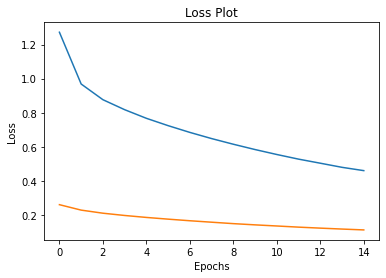

In [63]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model with 50 Epoches(Total) 
    - Append 35 more Epoches to the Previous Model

In [64]:
EPOCHS = 50

for epoch in tqdm.tqdm(range(15, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  3%|▎         | 1/35 [01:17<43:56, 77.55s/it]

For epoch: 16, the train loss is 0.441, & test loss is 0.109
Time taken for 1 epoch 77.3874044418335 sec

Test loss has been reduced from 0.113 to 0.109


  6%|▌         | 2/35 [02:35<42:45, 77.74s/it]

For epoch: 17, the train loss is 0.423, & test loss is 0.105
Time taken for 1 epoch 77.6930661201477 sec

Test loss has been reduced from 0.109 to 0.105


  9%|▊         | 3/35 [03:53<41:28, 77.76s/it]

For epoch: 18, the train loss is 0.406, & test loss is 0.100
Time taken for 1 epoch 77.618399143219 sec

Test loss has been reduced from 0.105 to 0.100
For epoch: 19, the train loss is 0.392, & test loss is 0.097
Time taken for 1 epoch 77.29001688957214 sec

Test loss has been reduced from 0.100 to 0.097


 14%|█▍        | 5/35 [06:28<38:50, 77.70s/it]

For epoch: 20, the train loss is 0.377, & test loss is 0.093
Time taken for 1 epoch 77.57230305671692 sec

Test loss has been reduced from 0.097 to 0.093


 17%|█▋        | 6/35 [07:46<37:34, 77.75s/it]

For epoch: 21, the train loss is 0.364, & test loss is 0.090
Time taken for 1 epoch 77.67901039123535 sec

Test loss has been reduced from 0.093 to 0.090


 20%|██        | 7/35 [09:04<36:18, 77.79s/it]

For epoch: 22, the train loss is 0.354, & test loss is 0.087
Time taken for 1 epoch 77.7199969291687 sec

Test loss has been reduced from 0.090 to 0.087


 23%|██▎       | 8/35 [10:21<34:59, 77.74s/it]

For epoch: 23, the train loss is 0.342, & test loss is 0.084
Time taken for 1 epoch 77.44716882705688 sec

Test loss has been reduced from 0.087 to 0.084


 26%|██▌       | 9/35 [11:39<33:42, 77.77s/it]

For epoch: 24, the train loss is 0.332, & test loss is 0.082
Time taken for 1 epoch 77.67781686782837 sec

Test loss has been reduced from 0.084 to 0.082
For epoch: 25, the train loss is 0.323, & test loss is 0.080
Time taken for 1 epoch 77.60923886299133 sec

Test loss has been reduced from 0.082 to 0.080


 31%|███▏      | 11/35 [14:15<31:06, 77.79s/it]

For epoch: 26, the train loss is 0.315, & test loss is 0.077
Time taken for 1 epoch 77.59575891494751 sec

Test loss has been reduced from 0.080 to 0.077


 34%|███▍      | 12/35 [15:33<29:48, 77.78s/it]

For epoch: 27, the train loss is 0.307, & test loss is 0.076
Time taken for 1 epoch 77.58110117912292 sec

Test loss has been reduced from 0.077 to 0.076


 37%|███▋      | 13/35 [16:50<28:30, 77.73s/it]

For epoch: 28, the train loss is 0.297, & test loss is 0.073
Time taken for 1 epoch 77.45727133750916 sec

Test loss has been reduced from 0.076 to 0.073


 40%|████      | 14/35 [18:08<27:12, 77.72s/it]

For epoch: 29, the train loss is 0.290, & test loss is 0.073
Time taken for 1 epoch 77.53423380851746 sec

Test loss has been reduced from 0.073 to 0.073


 43%|████▎     | 15/35 [19:25<25:53, 77.69s/it]

For epoch: 30, the train loss is 0.283, & test loss is 0.071
Time taken for 1 epoch 77.43772625923157 sec

Test loss has been reduced from 0.073 to 0.071


 46%|████▌     | 16/35 [20:43<24:37, 77.74s/it]

For epoch: 31, the train loss is 0.278, & test loss is 0.070
Time taken for 1 epoch 77.70624279975891 sec

Test loss has been reduced from 0.071 to 0.070


 49%|████▊     | 17/35 [22:01<23:17, 77.65s/it]

For epoch: 32, the train loss is 0.273, & test loss is 0.067
Time taken for 1 epoch 77.27295231819153 sec

Test loss has been reduced from 0.070 to 0.067


 51%|█████▏    | 18/35 [23:18<22:00, 77.66s/it]

For epoch: 33, the train loss is 0.264, & test loss is 0.066
Time taken for 1 epoch 77.516277551651 sec

Test loss has been reduced from 0.067 to 0.066


 54%|█████▍    | 19/35 [24:36<20:43, 77.75s/it]

For epoch: 34, the train loss is 0.264, & test loss is 0.065
Time taken for 1 epoch 77.77783417701721 sec

Test loss has been reduced from 0.066 to 0.065


 57%|█████▋    | 20/35 [25:54<19:25, 77.72s/it]

For epoch: 35, the train loss is 0.255, & test loss is 0.064
Time taken for 1 epoch 77.47961640357971 sec

Test loss has been reduced from 0.065 to 0.064


 60%|██████    | 21/35 [27:12<18:08, 77.74s/it]

For epoch: 36, the train loss is 0.251, & test loss is 0.062
Time taken for 1 epoch 77.61377739906311 sec

Test loss has been reduced from 0.064 to 0.062


 63%|██████▎   | 22/35 [28:30<16:51, 77.83s/it]

For epoch: 37, the train loss is 0.244, & test loss is 0.062
Time taken for 1 epoch 77.85339307785034 sec

Test loss has been reduced from 0.062 to 0.062


 66%|██████▌   | 23/35 [29:48<15:33, 77.76s/it]

For epoch: 38, the train loss is 0.241, & test loss is 0.061
Time taken for 1 epoch 77.43530488014221 sec

Test loss has been reduced from 0.062 to 0.061


 69%|██████▊   | 24/35 [31:05<14:15, 77.80s/it]

For epoch: 39, the train loss is 0.238, & test loss is 0.060
Time taken for 1 epoch 77.70735025405884 sec

Test loss has been reduced from 0.061 to 0.060


 71%|███████▏  | 25/35 [32:23<12:58, 77.80s/it]

For epoch: 40, the train loss is 0.235, & test loss is 0.059
Time taken for 1 epoch 77.61920237541199 sec

Test loss has been reduced from 0.060 to 0.059


 74%|███████▍  | 26/35 [33:41<11:40, 77.78s/it]

For epoch: 41, the train loss is 0.230, & test loss is 0.058
Time taken for 1 epoch 77.56651878356934 sec

Test loss has been reduced from 0.059 to 0.058


 77%|███████▋  | 27/35 [34:58<10:21, 77.68s/it]

For epoch: 42, the train loss is 0.226, & test loss is 0.057
Time taken for 1 epoch 77.26837944984436 sec

Test loss has been reduced from 0.058 to 0.057


 80%|████████  | 28/35 [36:16<09:03, 77.71s/it]

For epoch: 43, the train loss is 0.223, & test loss is 0.056
Time taken for 1 epoch 77.59027242660522 sec

Test loss has been reduced from 0.057 to 0.056


 83%|████████▎ | 29/35 [37:34<07:45, 77.62s/it]

For epoch: 44, the train loss is 0.221, & test loss is 0.055
Time taken for 1 epoch 77.2343521118164 sec

Test loss has been reduced from 0.056 to 0.055


 86%|████████▌ | 30/35 [38:51<06:28, 77.61s/it]

For epoch: 45, the train loss is 0.219, & test loss is 0.054
Time taken for 1 epoch 77.41055727005005 sec

Test loss has been reduced from 0.055 to 0.054


 89%|████████▊ | 31/35 [40:09<05:10, 77.58s/it]

For epoch: 46, the train loss is 0.217, & test loss is 0.054
Time taken for 1 epoch 77.35999059677124 sec

Test loss has been reduced from 0.054 to 0.054


 91%|█████████▏| 32/35 [41:26<03:52, 77.62s/it]

For epoch: 47, the train loss is 0.213, & test loss is 0.053
Time taken for 1 epoch 77.5504105091095 sec

Test loss has been reduced from 0.054 to 0.053


 94%|█████████▍| 33/35 [42:44<02:35, 77.58s/it]

For epoch: 48, the train loss is 0.210, & test loss is 0.052
Time taken for 1 epoch 77.298757314682 sec

Test loss has been reduced from 0.053 to 0.052


 97%|█████████▋| 34/35 [44:01<01:17, 77.50s/it]

For epoch: 49, the train loss is 0.208, & test loss is 0.051
Time taken for 1 epoch 77.1369080543518 sec

Test loss has been reduced from 0.052 to 0.051


100%|██████████| 35/35 [45:19<00:00, 77.70s/it]

For epoch: 50, the train loss is 0.204, & test loss is 0.052
Time taken for 1 epoch 77.79156827926636 sec



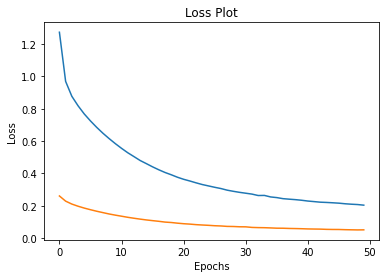

In [65]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [66]:
def evaluate(image):
    attention_features_shape = 64
    max_length = 39
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)         #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model( temp_input )  # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() # extract the predicted id(embedded value) which carries the max value
        word = tokenizer.index_word[predicted_id]        # map the id to the word from tokenizer 
        result.append(word)                              # append the value to the result list
        

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [67]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [68]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [69]:
from nltk.translate.bleu_score import sentence_bleu

In [70]:
def filt_text(text):
    filt=['<start>','UNK','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

7336
/kaggle/input/flickr8k/Images/3382679230_baef3d1eaa.jpg
BELU score: 91.2167909070388
Real Caption: the woman in blue appears to blowing glass while a child looks on
Prediction Caption: a woman in blue appears to blowing glass while a child looks on


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



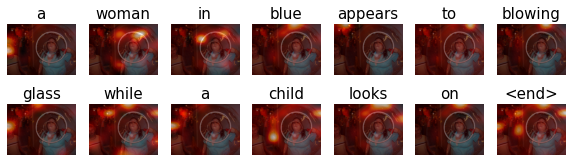

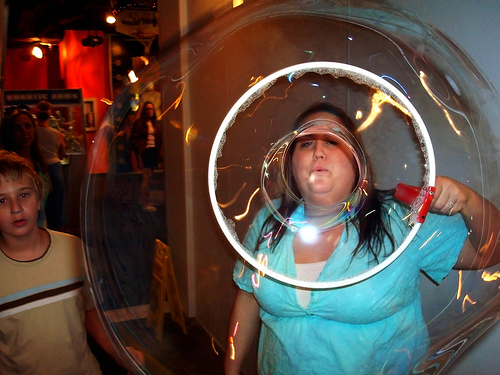

In [71]:

rid = np.random.randint(0, len(img_test)) 

test_image = img_test[rid]
print(rid)
print(test_image)

#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25)) #set your weights)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [72]:
# captions=beam_evaluate(test_image)
# print(captions)

2575
/kaggle/input/flickr8k/Images/1075716537_62105738b4.jpg
BELU score: 5.087740766179591e-153
Real Caption: the little boy rides his bicycle in a race
Prediction Caption: a little boy with a helmet


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning:


The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning:


The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



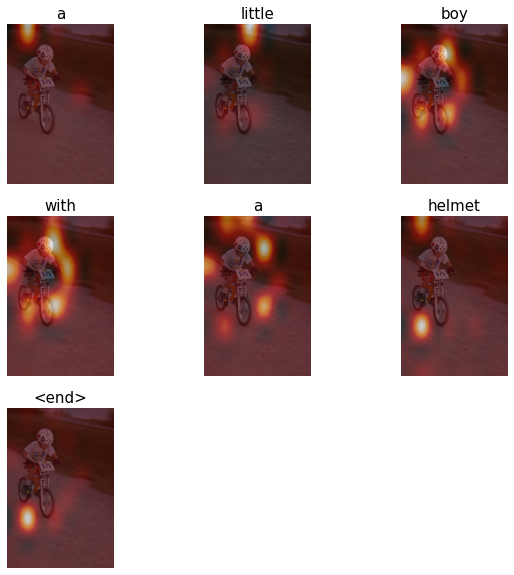

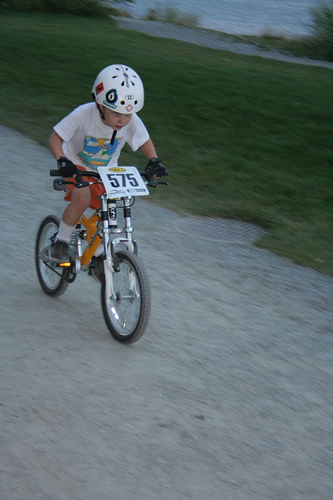

In [73]:

rid = np.random.randint(0, len(img_test)) 

test_image = img_test[rid]
print(rid)
print(test_image)

#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25)) #set your weights)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)